# Background

This is a website dedicated to reporting the findings of IRisk's Introduction to Monte Carlo Simulations Queueing Project, which ran from August of 2025 to December of 2025. This website will first give backround on Monte Carlo Simulations, how they apply to Queues, and walk through the research question and methods that were utilized this semester.

## What is a Monte Carlo Simulaton?

Named after a Casino, a Monte Carlo Simulation is a way to estimate the outcome and probability of a random process that isn't easily predictable, like a procedure that doesn't have a closed-form equation. It takes advantage of the fact that computers are able to run thousands of equations in fractions of seconds, and uses these equations generated to help estimate the expected value of a process. Monte Carlo Simulations are able to work as well as they do thanks to ideas like the Law of Large Numbers and Central Limit Thoerem. The law of large numbers states that as the sample size increases, the average of that sample approaches the population average. The Central Limit Theorem on the other hand states that, for large samples, the sampling distribution's distribution of sample means mimics a normal distribution, even if the distribution the sample comes from isn't normal. This benefits Monte Carlo Simulations because, through rapid repetition, we can make judgements on the expected value of a desired population OR easily manipulate sample data by transforming sample means into a normal distribution.  Monte Carlo Simulations have a variety of applications, whether it be to test the security of RSA Encryption, or to estimate the Price of Stock Call/Put Options.

### Example WITH closed form equation:

It's common knowledge that the most common dice roll from a pair of 2 standard six-sided dice is seven, not only because the expected value is easily computed, but because it can be observed in reality. If the probability of a dice roll didn't have a closed-form equation, we could estimate the most common dice roll by rolling two dice some large number of times, let's say 200, and taking the average across all 10,000 dice rolls. As one can see by the results below, as N increases, the calculated average dice roll approaches Seven!

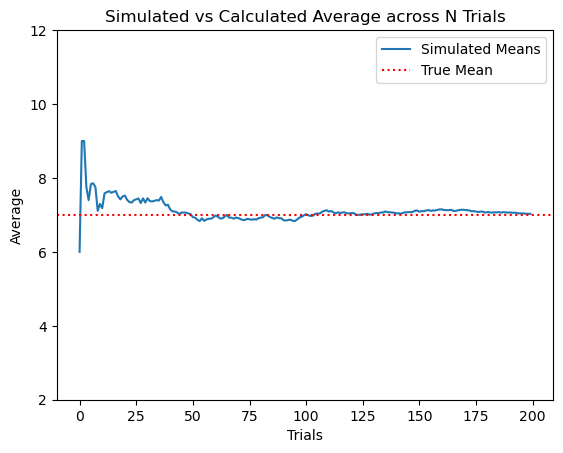

In [22]:
#Imports:
import numpy as np
import random
rng = np.random.default_rng(1337)
import matplotlib.pyplot as plt

N = 200 # our number of repetitions

rolls = [] # an array where we'll capture every dice rolled
averages = [] # an array that will record every cumulate average for each trial

for i in range(N):
    die1 = np.random.randint(1, 7) # outcome of first die roll
    die2 = np.random.randint(1, 7) # outcome of second die roll
    total = die1 + die2 # sum of dice roll

    rolls.append(total) # add this roll to our list of rolls

    avg = sum(rolls)/len(rolls) # take the average of all rolls so far

    averages.append(avg) # add the average of all rolls up until this repetition to our averages

plt.plot(averages, label="Simulated Means")
plt.axhline(y=7, color='r', linestyle=':', label="True Mean")
plt.title('Simulated vs Calculated Average across N Trials'); plt.xlabel('Trials'); plt.ylabel('Average')
plt.ylim(2,12)
plt.legend()



### Example WITHOUT closed form equation:

A notoriously difficult problem in Calculus is to find the Integral of $e^{-x^2}$. On top of being difficult to integrate, $e^{-x^2}$ has no closed form antiderivative. Using Monte Carlo simulations, however, we are able to generate a rough estimate of the area under the $e^{-x^2}$ curve! Since $e^{-x^2}$ is a symetrical function and tends to zero very quickly, we can randomly pick points in a rectangle where $0 \leq x \leq 2$ and $0 \leq y \leq 1$ and find the average of all points chosen that fit the criteria $ y \leq e^{x^2}$

Area under Bell Curve is Approximately:  1.7608


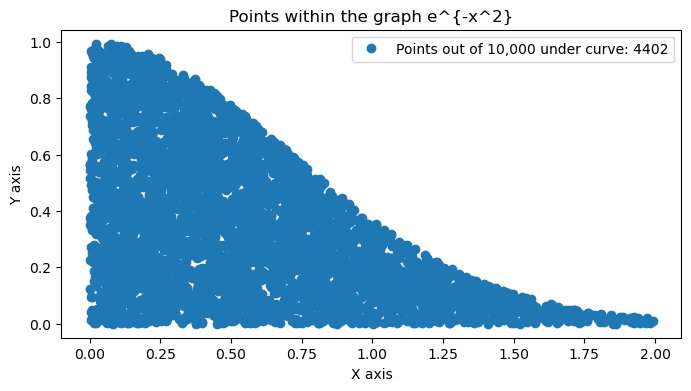

In [ ]:
#Imports:

N = 10_000

x_val = rng.uniform(0,1, size=N)*2 # Generate x values from 0 to 1 and scale by 2 for equal density
y_val = rng.uniform(0,1, size=N) # Generate y values from 0 to 1

x_transformed = np.exp(-(x_val**2)) # transfrom values of x to values of e^{-x^2}

y_less_than_x = 1*(y_val <= x_transformed) # Note all values where y <= e^{-x^2}

# Function that captures ONLY all x and y values that fit criteria
xs = []
ys = []
for i in range(N):
    if y_less_than_x[i] == 1:
        xs.append(x_val[i])
        ys.append(y_val[i])

# Plots all values recorded within the Curve
plt.figure(figsize=(8, 4)) 
plt.plot(xs, ys, 'o', label= f"Points out of 10,000 under curve: {len(ys)}")
plt.title('Points within the graph e^{-x^2}'); plt.xlabel('X axis'); plt.ylabel('Y axis')
plt.legend()

print("Area under Bell Curve is Approximately: ",2*2*(sum(y_less_than_x)/N))
# Multiplied by 2 once to scale 1:1 square to 2:1 rectange
# Multiplied by 2 a second time because bell curve is symmetrical


Now that readers are familiar with the general idea and process of a Monte Carlo Simulation, let's move on to how Monte Carlo Simulations help with estimating Queue wait times!

## What are Queueing Systems?

Queues are data structures that hold a list of variables. They are often FIFO (First in First Out), which is how many lines and queues work in the real world. This is different from a Stack which processes data LIFO (Last in First Out), kind of like if a teacher was given a stack of papers to grade, they'd first grade the paper that was most recently submited: the one on top. Queues are defined and classified through several factors, such as arrival distributions, process distributions, and server amounts. A common type of Queue is an M/M/1 Queue. The naming convention "x/x/n/..." is called Kendall's Notation and it's a way to classify queues. The first 2 letters in Kendall's notation refer to the arrival and process times respectively. The M's in M/M/1 stands for "Markovian" or "Memoryless." This means that every arrival time is memoryless, so anyone who arrives at a given time has no influence over the next person arriving. "Deterministic" (D) is another property that can fill this role, meaning arrivals always arrive at fixed intervals. Finally, the number in M/M/1 notation refers to the number of servers in the queue, just 1 in this case. There are more notations that follow x/x/n/... but we wil solely be focusing on these 3 numbers going forward.

Queues, as processes with arrival times, process times, and server numbers, can have their wait and process time estimated. This is most easily shown for an M/M/1 queue. For Markovian Poisson arrivals where the arrival time is $Exp(\lambda)$ and Markovian Exponential process times where the process time is $Exp(\mu)$, the mean Sojurn time (time between entering and exiting queue) can be calculated as $E[W] = 1/(\mu - \lambda)$ and the mean waiting time in the queue is $E[W_q] = \rho/\mu(1-\rho)$ where $\rho = \lambda/\mu$ and $\rho < 1$. If $\rho > 1$, or the arrival rate is greater than the process rate, the wait time blows up to infinity because more people are arriving than can be served. 

Let's look at example where $\lambda = 4$ and $\mu = 6$ (and therefore $\rho = 2/3$). We know that, from the formula, our estimated time waiting in the queue will be $(2/3)/6(1/3)$ or $1/3$ and our estimated time in the queue will be $1/(6-4)$ or $1/2$. We can see this through Monte Carlo Simulation:

In [55]:
N = 10_000

lam = 4
mu = 6

arrival = rng.exponential(1/lam, size=N) # different in-between arrival rates
service = rng.exponential(1/mu,  size=N) # different process times
cum_arrival = np.cumsum(arrival) # create timeline of arrival

start_service = np.empty(N)
finish_time   = np.empty(N)

start_service[0] = cum_arrival[0] # the first time service starts is the time the first client arrives
finish_time[0]   = start_service[0] + service[0] # the first time processing ends is when the first client is processed

for i in range(1, N): # for all subsequent arrivals
    start_service[i] = max(cum_arrival[i], finish_time[i-1])
    # ^ The next client starts getting processed either when they arrive, or after the person in front of them finishes processing
    finish_time[i]   = start_service[i] + service[i]
    # ^ The next service time is from when the client starts getting processed to when they finish processing

wait_in_queue = start_service - cum_arrival # time from when a client arrives to when they start getting served
sojourn_time  = finish_time   - cum_arrival # time from when a client arrives to when they finish getting served

print("Calculated Wait in Queue:",1/3)
print("Simulated Wait in Queue:",sum(wait_in_queue)/len(wait_in_queue))
print()
print("Calculated Sojurn Time:",1/2)
print("Simulated Sojurn Time:",sum(sojourn_time)/len(sojourn_time))

Calculated Wait in Queue: 0.3333333333333333
Simulated Wait in Queue: 0.3382658105095137

Calculated Sojurn Time: 0.5
Simulated Sojurn Time: 0.5056378302863985


Now that we have the background for Monte Carlo Simulations and Queues down, let's move on to the topic of our research!